In [6]:
import os
import time
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import warnings
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
from sklearn.exceptions import ConvergenceWarning  # Import ConvergenceWarning
from IPython.display import clear_output

# Suppress warnings and set logging
warnings.filterwarnings("ignore", category=ConvergenceWarning)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [7]:
# Function to load data
def load_data(file_path):
    """Load dataset from the specified file path."""
    try:
        data = pd.read_csv(file_path)
        logging.info(f"Dataset loaded successfully from {file_path}")
        return data
    except FileNotFoundError:
        logging.error(f"File not found at {file_path}")
        exit(1)

# Function to preprocess data
def preprocess_data(data):
    """Preprocess data by handling categorical variables and scaling numerical features."""
    logging.info("Starting data preprocessing")
    # One-hot encode categorical variables
    categorical_columns = data.select_dtypes(include=['object']).columns
    data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

    # Convert boolean columns to integers
    bool_columns = data.select_dtypes(include=['bool']).columns
    data[bool_columns] = data[bool_columns].astype(int)

    # Scale numerical features
    scaler = StandardScaler()
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    logging.info("Data preprocessing completed")
    return data

# Function to train models and evaluate performance
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train models and evaluate their performance."""
    models_and_params = {
        "Lasso": (Lasso(fit_intercept=False), {"alpha": np.concatenate([np.logspace(-4, -1, 10), np.linspace(0.1, 1.0, 5)])}),
    }

    results = []
    for name, (model, params) in models_and_params.items():
        try:
            grid_search = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
            grid_search.fit(X_train, y_train)

            best_model = grid_search.best_estimator_
            best_score = -grid_search.best_score_  # Convert to positive MAE
            y_test_pred = best_model.predict(X_test)

            # Calculate metrics
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            results.append({
                "Model": name,
                "Mean_CV_MAE": best_score,
                "Test_MAE": test_mae,
                "Test_MSE": test_mse,
                "Test_R2": test_r2,
                "Best_Params": grid_search.best_params_,
                "Best_Model": best_model
            })

        except Exception as e:
            logging.error(f"Model {name} failed with error: {e}")

    results_df = pd.DataFrame(results).sort_values(by="Test_MAE")
    return results_df

# Function to display feature importance and equation
def display_feature_importance_and_equation(model, feature_names):
    """Display feature importance for linear models and print the equation."""
    if hasattr(model, "coef_"):
        coefficients = model.coef_
        intercept = model.intercept_
        non_zero_coefficients = [(coef, feature) for coef, feature in zip(coefficients, feature_names) if coef != 0]

        print("\nUseful Features (Non-zero Coefficients):")
        for coef, feature in non_zero_coefficients:
            print(f"\t{feature}: {coef:.4f}")

        zero_coefficients = [(coef, feature) for coef, feature in zip(coefficients, feature_names) if coef == 0]
        print("\nNot Useful Features (Zero Coefficients):")
        for _, feature in zero_coefficients:
            print(f"\t{feature}")

        # Print the regression equation
        equation_terms = [f"{coef:.4f} * {feature}" for coef, feature in non_zero_coefficients]
        equation = " + ".join(equation_terms)
        equation = f"y = {equation} + {intercept:.4f}"
        print("\nRegression Equation:")
        print(equation)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh([feature for _, feature in non_zero_coefficients], [coef for coef, _ in non_zero_coefficients], color="skyblue")
        plt.title("Feature Importance")
        plt.xlabel("Coefficient Value")
        plt.ylabel("Feature")
        plt.show()

# Function for dynamic plotting
def dynamic_plotting(train_sizes, X_train, y_train, X_test, y_test, best_params):
    """Dynamically plot MAE, R², and coefficients as training size varies."""
    mae_scores = []
    r2_scores = []
    coefficients = []
    feature_names = X_train.columns.tolist()

    for train_size in train_sizes:
        # Subsample training data
        X_train_sub = X_train.iloc[:train_size]
        y_train_sub = y_train[:train_size]

        # Train Lasso regressor
        lasso = Lasso(**best_params)
        lasso.fit(X_train_sub, y_train_sub)

        # Predict and evaluate
        y_pred = lasso.predict(X_test)
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        coefficients.append(lasso.coef_)

        # Clear previous output
        clear_output(wait=True)

        # Create MAE plot
        fig_mae = go.Figure()
        fig_mae.add_trace(go.Scatter(
            x=train_sizes[:len(mae_scores)],
            y=mae_scores,
            mode='lines+markers',
            name='MAE',
            line=dict(color='blue')
        ))
        fig_mae.update_layout(
            title='Dynamic Effect of Training Size on MAE',
            xaxis_title='Training Size',
            yaxis_title='Mean Absolute Error (MAE)',
            legend_title='Metric'
        )

        # Create R² plot
        fig_r2 = go.Figure()
        fig_r2.add_trace(go.Scatter(
            x=train_sizes[:len(r2_scores)],
            y=r2_scores,
            mode='lines+markers',
            name='R² Score',
            line=dict(color='green')
        ))
        fig_r2.update_layout(
            title='Dynamic Effect of Training Size on R²',
            xaxis_title='Training Size',
            yaxis_title='R² Score',
            legend_title='Metric'
        )

        # Create Coefficients plot
        fig_coeff = go.Figure()
        coefficients_array = np.array(coefficients)
        for i, feature_name in enumerate(feature_names):
            fig_coeff.add_trace(go.Scatter(
                x=train_sizes[:len(mae_scores)],
                y=coefficients_array[:, i],
                mode='lines+markers',
                name=feature_name
            ))
        fig_coeff.update_layout(
            title='Dynamic Effect of Training Size on Coefficients',
            xaxis_title='Training Size',
            yaxis_title='Coefficient Values',
            legend_title='Feature Names'
        )

        # Display updated figures
        fig_mae.show()
        fig_r2.show()
        fig_coeff.show()

        time.sleep(1)

2025-01-18 08:52:05,785 - INFO - Dataset loaded successfully from /workspaces/Portfolio/projects/DynamicPricingOptimization/data/dynamic_pricing.csv
2025-01-18 08:52:05,788 - INFO - Starting data preprocessing


2025-01-18 08:52:05,811 - INFO - Data preprocessing completed


   Model  Mean_CV_MAE  Test_MAE  Test_MSE   Test_R2      Best_Params
0  Lasso     0.273337  0.280788  0.133323  0.849305  {'alpha': 0.01}

Useful Features (Non-zero Coefficients):
	Number_of_Drivers: 0.0339
	Average_Ratings: 0.0071
	Expected_Ride_Duration: 0.9203
	Time_of_Booking_Evening: -0.0039
	Vehicle_Type_Premium: 0.1128

Not Useful Features (Zero Coefficients):
	Number_of_Riders
	Number_of_Past_Rides
	Location_Category_Suburban
	Location_Category_Urban
	Customer_Loyalty_Status_Regular
	Customer_Loyalty_Status_Silver
	Time_of_Booking_Morning
	Time_of_Booking_Night

Regression Equation:
y = 0.0339 * Number_of_Drivers + 0.0071 * Average_Ratings + 0.9203 * Expected_Ride_Duration + -0.0039 * Time_of_Booking_Evening + 0.1128 * Vehicle_Type_Premium + 0.0000


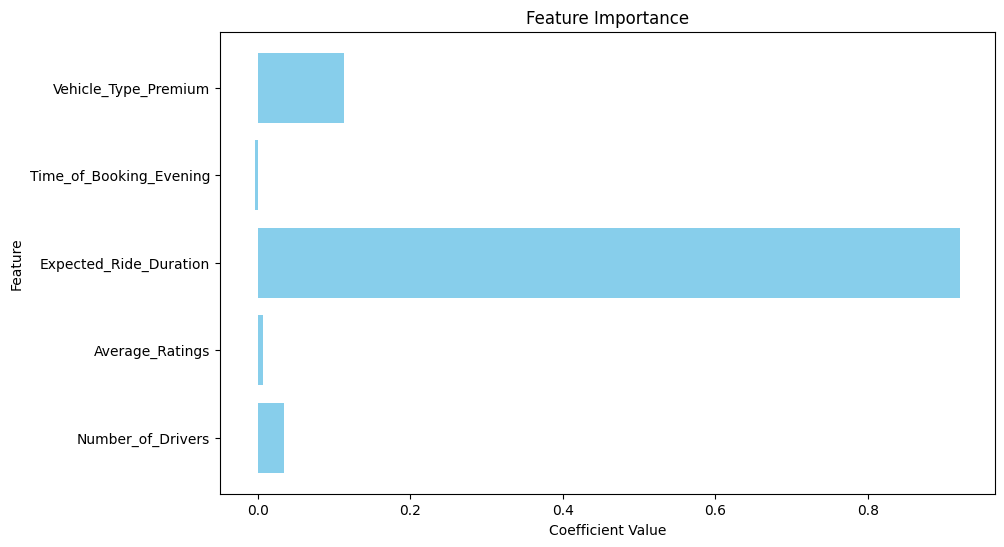

In [8]:

"""Main function to execute the script."""
# File path configuration
file_path = os.path.join(os.getcwd(), "data", "dynamic_pricing.csv")

# Load and preprocess data
data = load_data(file_path)
data = preprocess_data(data)

# Prepare features and target
X = data.drop('Historical_Cost_of_Ride', axis=1)
y = data['Historical_Cost_of_Ride']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train and evaluate models
results_df = train_and_evaluate_models(X_train, X_test, y_train, y_test)
print(results_df[["Model", "Mean_CV_MAE", "Test_MAE", "Test_MSE", "Test_R2", "Best_Params"]])

# Display feature importance and equation for the best model
top_model_row = results_df.iloc[0]
top_model = top_model_row["Best_Model"]
best_params = top_model_row["Best_Params"]
display_feature_importance_and_equation(top_model, X_train.columns)





In [9]:
# Perform dynamic plotting
train_sizes = np.linspace(50, len(X_train), 10, dtype=int)
dynamic_plotting(train_sizes, X_train, y_train, X_test, y_test, best_params)